# Performing Matching for Causal Inference on "Lalonde" Dataset


Data sourced from

https://github.com/robjellis/lalonde/blob/master/lalonde_data.csv


Based on the notebook demonstrating the causalinference package, at:

https://rugg2.github.io/Lalonde%20dataset%20-%20Causal%20Inference.html

## Importing Packages

In [1]:
##Import packages

#Data Processing
import pandas as pd
import numpy as np

#Finding the data on our system
import pathlib

#Matching library
from causalinference import CausalModel

#Scaling
from sklearn.preprocessing import StandardScaler

#Splitting data into training and test
from sklearn.model_selection import train_test_split

#Metrics to evaluate


#Plotting library
import matplotlib.pyplot as plt

## Import Data

### Understanding the Dataset

The Lalonde dataset is a classic example used for causal inference.
# I should write something about the original paper here, and then review other things that I've written


In this dataset, we see individuals and try to find the impact that the treatment (an educational training) has on their income in 1978. All the information we have on each individual is as follows:

- ID - a unique identifier for the individual (we'll drop this because it doesn't tell us anything)
- treat - 1 or 0 - if the individual recieved the treatment
- age - integer - the age of the individual
- educ - int - the number of years of education that the individual has recieved
- black - 1 or 0 - if the individual is black
- hispan - 1 or 0 - if the individual is hispanic
- married - 1 or 0 - if the individual is married
- nodegree - 1 or 0 - if the individual does not have a degree (0 = degree, 1 = no degree)
- re74 - real number - the income of the individual in 1974 (prior to the treatment)
- re75 - real number - the income of the individual in 1975 (prior to the treatment)
- re78 - real number - the outcome variable - the income of the individual in 1978 (after treatment of those who recieved it)

Unfortunately, re74 and re75 have a lot of missing values, and are overall very correlated with each other. This makes them innapropriate for matching on. Because of this, we will drop these columns and not use them in our analysis.

In [2]:
#Import data

#Find the file from a local directiory
p = str(pathlib.Path().resolve()).replace("\\Notebooks\\Matching and Causal Inference", "")
p += ("\\Data\\Raw\\lalonde_data.csv")
p = pathlib.Path(p).resolve()

#Read into a pandas dataframe
df = pd.read_csv(p)

#Preview the dataset
df.head()

,ID,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [3]:
#Dropping na rows and columns as discussed above

#Drop na rows
df = df.dropna()

#Drop ID, re74 and re75 columns
df = df.drop(["ID", "re74", "re75"], axis=1)

#Show the new DataFrame
df.head()

,treat,age,educ,black,hispan,married,nodegree,re78
0,1,37,11,1,0,1,1,9930.0460
1,1,22,9,0,1,0,1,3595.8940
2,1,30,12,1,0,0,0,24909.4500
3,1,27,11,1,0,0,1,7506.1460
4,1,33,8,1,0,0,1,289.7899


## Most Simple Treatment Effect

The absolutely most simple way that we can get a treatment effect is by comparing the means of the data. Currently, the data is imbalanced, with 429 untreated individuals, and 185 treated invidiuals. This method is not valid for finding causality (ie, we can't say that the treatment here "causes" any difference in income), as it does not take into account factors determining which people sign up for the treatment.

In [16]:
#Find the mean income of individuals who took part in the training
mean_treat = np.mean(df[df["treat"] == 1]["re78"])

print(mean_treat)

6349.143530270271


In [17]:
#Find the mean income of those who did not take part in the training
mean_control = np.mean(df[df["treat"] == 0]["re78"])

print(mean_control)

6984.169742307692


We see here that the mean income for those taking the treatment is lower! Is the treatment worse than nothing?

## Data Exploration

From a bit of exploration, we can see that the distribution of individuals in each group is really different. This tells us, like we might expect, that the types of people that take part in the treatment programme are different to those who don't. We can see straight away, for example, that the ages of those in the treatment group are generally younger than those in the control group.

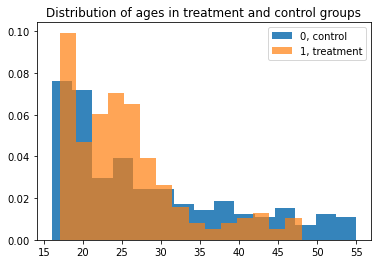

In [35]:
#Plot the treated and control group's age distribution
plt.hist(df[df["treat"] == 0]["age"], label="0, control", bins=15, density=True, alpha=0.9)
plt.hist(df[df["treat"] == 1]["age"], label="1, treatment", bins=15, density=True, alpha=0.7)

plt.title("Distribution of ages in treatment and control groups")
plt.legend()

We don't really need to understand the difference in distributions past here in this case, as we have shown that they're different. We'll fix this in matching later - so we can approximate a causal relationship.

However, we can look at a couple of our other covariates, just to drive home the point of the difference, and the effect of self-selection on the groups

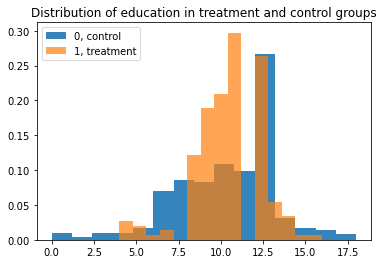

In [36]:
#Plot the treated and control group's education distribution
plt.hist(df[df["treat"] == 0]["educ"], label="0, control", bins=15, density=True, alpha=0.9)
plt.hist(df[df["treat"] == 1]["educ"], label="1, treatment", bins=15, density=True, alpha=0.7)

plt.title("Distribution of education in treatment and control groups")
plt.legend()

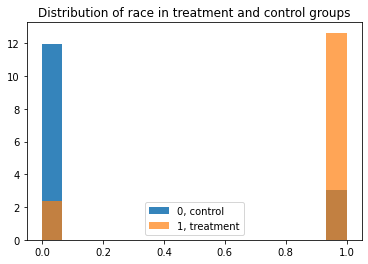

In [38]:
#Plot the treated and control group's racial distribution
plt.hist(df[df["treat"] == 0]["black"], label="0, control", bins=15, density=True, alpha=0.9)
plt.hist(df[df["treat"] == 1]["black"], label="1, treatment", bins=15, density=True, alpha=0.7)

plt.title("Distribution of race in treatment and control groups")
plt.legend()

This one is particularly telling - the proportion of black people in the treatment group is way lower than the control group.

In [40]:
causal = CausalModel(
    Y=df['re78'].values, 
    D=df['treat'].values, 
    X=df[["age", "educ", "black", "hispan", "married", "nodegree"]].values)

In [51]:
causal.est_via_matching(bias_adj=True, matches=1)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     57.339   1608.911      0.036      0.972  -3096.126   3210.804
           ATC   -306.845   2055.198     -0.149      0.881  -4335.034   3721.343
           ATT    901.852   1795.465      0.502      0.615  -2617.259   4420.963

